In [1]:
import torch
from transformers import AutoModelForCausalLM
from transformers import AutoTokenizer
import sys
from datetime import datetime
sys.path.append("../")
sys.path.append("../../")
torch.manual_seed(42)
device = "cuda" if torch.cuda.is_available() else "cpu"
model_id = "gpt2"

tokenizer_with_prefix_space = AutoTokenizer.from_pretrained(model_id, use_fast=True, add_prefix_space=True, local_files_only = False)
model = AutoModelForCausalLM.from_pretrained(model_id,
                                            return_dict_in_generate=True,
                                            pad_token_id=tokenizer_with_prefix_space.eos_token_id).to(device)

/opt/conda/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [2]:
from gpt2.gpt2_probabilistic_model_wrapper import GPT2_probabilistic_model_wrapper
from guiding_wfa_doctor_a_the import alphabet_A, alphabet_B
wrapper_with_prefix_space_A = GPT2_probabilistic_model_wrapper(100, alphabet_A, device, model, tokenizer_with_prefix_space)
wrapper_with_prefix_space_B = GPT2_probabilistic_model_wrapper(100, alphabet_B, device, model, tokenizer_with_prefix_space)


In [3]:
from guiding_wfa_doctor_a_the import get_doctor_wfa_A, get_doctor_wfa_B
from pythautomata.utilities.guiding_wfa_sequence_generator import GuidingWDFASequenceGenerator
guiding_wfa_A = get_doctor_wfa_A(wrapper_with_prefix_space_A.terminal_symbol)
guiding_generator = GuidingWDFASequenceGenerator(guiding_wfa_A, None)
guiding_generator.generate_words(15)

[ϵ,
 The doctor was very famous.,He,saved a,black,man,
 The doctor was very famous.,
 The doctor was very famous.,He,saved a,black,woman,
 ϵ,
 The doctor was very famous.,
 The doctor was very famous.,
 The doctor was very famous.,He,saved a,black,
 ϵ,
 The doctor was very famous.,
 The doctor was very famous.,He,saved a,white,woman,
 The doctor was very famous.,
 The doctor was very famous.,
 ϵ,
 The doctor was very famous.,She,saved a]

In [4]:
guiding_wfa_B = get_doctor_wfa_B(wrapper_with_prefix_space_B.terminal_symbol)
guiding_generator = GuidingWDFASequenceGenerator(guiding_wfa_B, None)
guiding_generator.generate_words(15)

[ϵ,
 The doctor was very famous.,He,saved the,black,man,
 The doctor was very famous.,
 The doctor was very famous.,He,saved the,black,woman,
 ϵ,
 The doctor was very famous.,
 The doctor was very famous.,
 The doctor was very famous.,He,saved the,black,
 ϵ,
 The doctor was very famous.,
 The doctor was very famous.,He,saved the,white,woman,
 The doctor was very famous.,
 The doctor was very famous.,
 ϵ,
 The doctor was very famous.,She,saved the]

# Using A

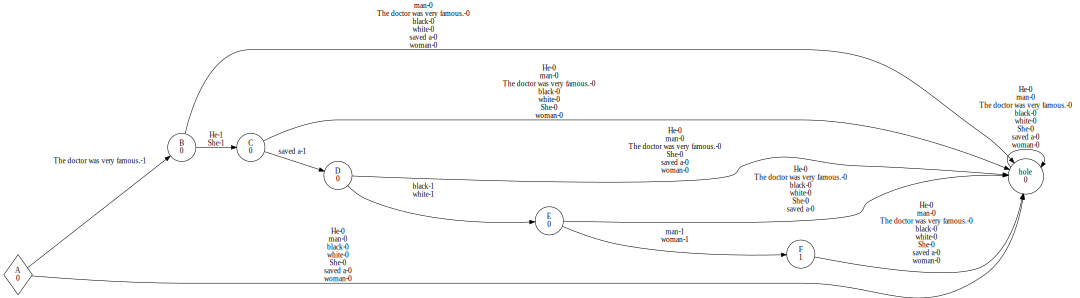

In [5]:
from pythautomata.model_exporters.dot_exporters.wfa_dot_exporting_strategy import WFADotExportingStrategy
from IPython.display import display

exporter = WFADotExportingStrategy()
graph = exporter.create_graph(guiding_wfa_A)

display(graph)

In [6]:
exporter.export(guiding_wfa_A,"./")

# Using The

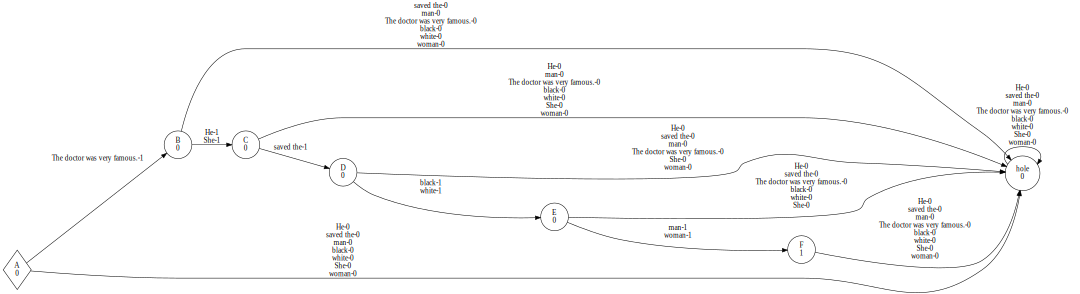

In [7]:
from pythautomata.model_exporters.dot_exporters.wfa_dot_exporting_strategy import WFADotExportingStrategy
from IPython.display import display

exporter = WFADotExportingStrategy()
graph = exporter.create_graph(guiding_wfa_B)

display(graph)

In [8]:
exporter.export(guiding_wfa_B,"./")

In [9]:
from src.synchronic_model_guided_language_model import SynchronicModelGuidedLanguageModel

property_model_A = get_doctor_wfa_A(wrapper_with_prefix_space_A.terminal_symbol)
property_model_B = get_doctor_wfa_B(wrapper_with_prefix_space_B.terminal_symbol)
synchronic_model_with_prefix_space_A = SynchronicModelGuidedLanguageModel(wrapper_with_prefix_space_A, property_model_A, model_name="GUIDED_GPT2", max_seq_length=6,normalize_outputs=True, top_k = 2)
synchronic_model_with_prefix_space_B = SynchronicModelGuidedLanguageModel(wrapper_with_prefix_space_B, property_model_B, model_name="GUIDED_GPT2", max_seq_length=6,normalize_outputs=True, top_k = 2)



In [10]:
from pymodelextractor.teachers.pac_probabilistic_teacher import PACProbabilisticTeacher
from src.hypothesis_aware_sample_probabilistic_teacher import HypothesisAwareSampleProbabilisticTeacher
from pymodelextractor.learners.observation_tree_learners.bounded_pdfa_quantization_n_ary_tree_learner import BoundedPDFAQuantizationNAryTreeLearner
from pythautomata.utilities.probability_partitioner import TopKProbabilityPartitioner, QuantizationProbabilityPartitioner, RankingPartitioner
from pythautomata.model_comparators.wfa_partition_comparison_strategy import WFAPartitionComparator
from pythautomata.utilities.uniform_word_sequence_generator import UniformWordSequenceGenerator


partitioner = QuantizationProbabilityPartitioner(10)
comparator = WFAPartitionComparator(partitioner)
epsilon = 0.1
delta = epsilon
sequence_generator = guiding_generator
max_states = 30
max_query_length = 100


In [11]:
teacher_with_prefix_space_A = HypothesisAwareSampleProbabilisticTeacher(synchronic_model_with_prefix_space_A, 
                                                                        comparator, 30)

teacher_with_prefix_space_B = HypothesisAwareSampleProbabilisticTeacher(synchronic_model_with_prefix_space_B,
                                                                        comparator, 30)

In [12]:
learner = BoundedPDFAQuantizationNAryTreeLearner(partitioner, 
                                                 max_states, 
                                                 max_query_length, 
                                                 max_seconds_run = None, 
                                                 generate_partial_hipothesis = True, 
                                                 pre_cache_queries_for_building_hipothesis = True,  
                                                 check_probabilistic_hipothesis = False, 
                                                 omit_zero_transitions=True)

In [17]:
from pythautomata.model_exporters.dot_exporters.wfa_dot_exporting_strategy import WFADotExportingStrategy
import time


start_time = time.time()
learning_result_with_prefix_space_A = learner.learn(teacher_with_prefix_space_A, verbose = True)
print("--- %s seconds ---" % (time.time() - start_time))

exporter = WFADotExportingStrategy()
actual_date = datetime.now().strftime("%d_%m_%Y_%H_%M_%S")
exporter.export(learning_result_with_prefix_space_A.model,"./", "pdfa_doctor_a"+actual_date)


Size before update: 8
CE: The doctor was very famous.,She,saved a,white
----update_node----
Old Node (new Leaf) The doctor was very famous.,He,saved a
New Leaf The doctor was very famous.,She,saved a
dict_keys([The doctor was very famous., ϵ, The doctor was very famous.,He, The doctor was very famous.,He,saved a, The doctor was very famous.,He,saved a,black, The doctor was very famous.,He,saved a,white, The doctor was very famous.,He,saved a,black,man, The doctor was very famous.,She,saved a,white])
dict_keys([The doctor was very famous., ϵ, The doctor was very famous.,He, The doctor was very famous.,He,saved a, The doctor was very famous.,He,saved a,black, The doctor was very famous.,He,saved a,white, The doctor was very famous.,He,saved a,black,man, The doctor was very famous.,She,saved a,white, The doctor was very famous.,She,saved a])
--------
Size after update: 11
Size before update: 11
CE: The doctor was very famous.,She,saved a,white
----update_node----
Old Node (new Leaf) The d

In [18]:
from pythautomata.model_exporters.dot_exporters.wfa_dot_exporting_strategy import WFADotExportingStrategy

start_time = time.time()
learning_result_with_prefix_space_B = learner.learn(teacher_with_prefix_space_B, verbose = True)
print("--- %s seconds ---" % (time.time() - start_time))

exporter = WFADotExportingStrategy()
actual_date = datetime.now().strftime("%d_%m_%Y_%H_%M_%S")
exporter.export(learning_result_with_prefix_space_B.model,"./", "pdfa_doctor_The"+actual_date)


--- 2.848384141921997 seconds ---


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


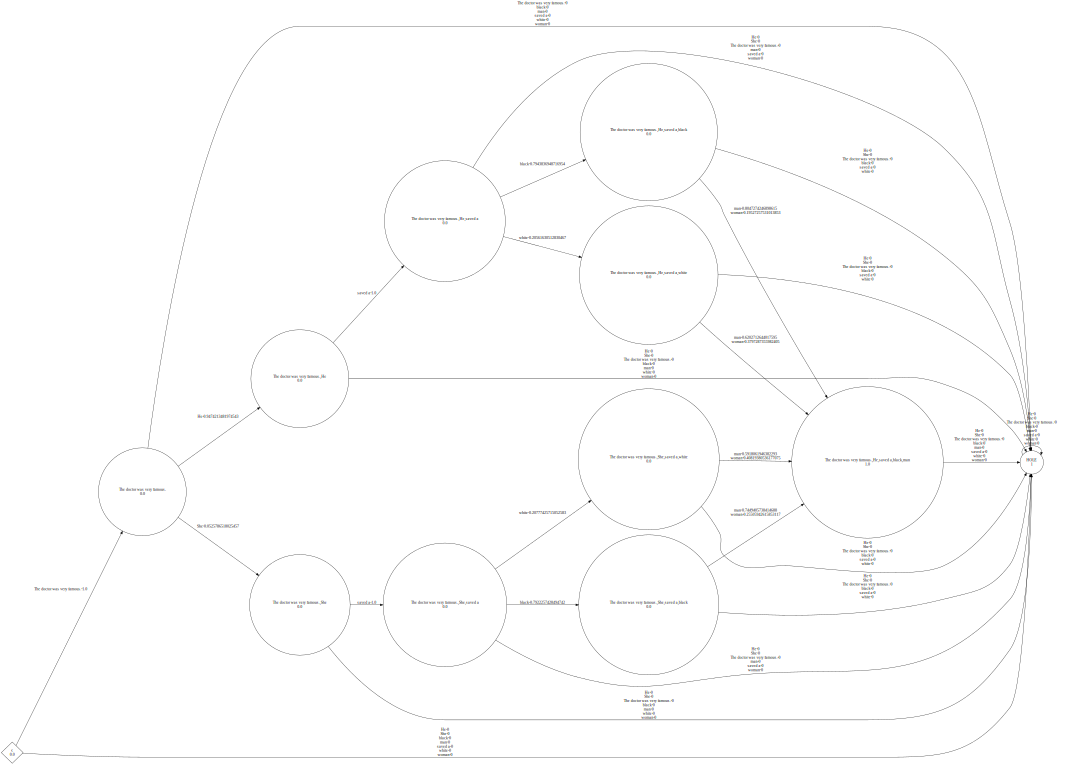

In [15]:
from pythautomata.model_exporters.dot_exporters.wfa_dot_exporting_strategy import WFADotExportingStrategy
from IPython.display import display

graph1 = exporter.create_graph(learning_result_with_prefix_space_A.model)
display(graph1)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


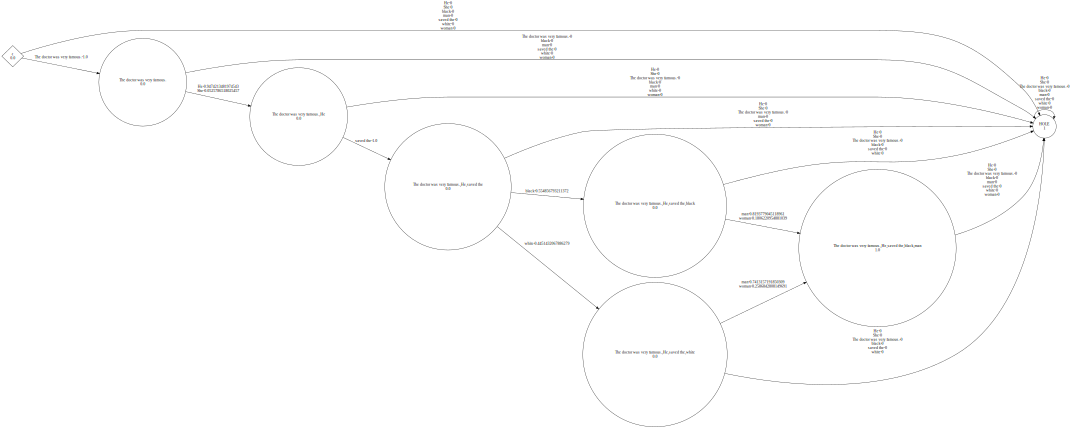

In [16]:
graph2 = exporter.create_graph(learning_result_with_prefix_space_B.model)
display(graph2)